#### A/B Testing

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
# In our hypothetical project, we've got users doing a test on a new UI.  Some got the new one, others the old one.  We're going to look at conversion rates.
# The regular UI has a conversion rate of 13%, and the client will be stoked about a 2% lift to 15% conversion.
# Now, we'll use an alpha of 0.05, and a power of 80% or 0.8 as standard.  
# The power here will essentially say we've got an 80% chance to capture the statistics to rightly reject the null hypothesis or not.

In [4]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # So this is going to calc our effect size, using that 13% and 15% we want, as defined in the experiment outline

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # So this calcs the number we need for the parameters we've set

required_n = ceil(required_n)                          # Rounds this to the next whole num                        

print(required_n)

4720


In [5]:
# As we can see above, based on the calculations that outline the different parameters we wanted in our experiment, we need 4,720 in our sample size

df = pd.read_csv("ab_data.csv")

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
# Excellent.  We can see the import worked, and we can also see there's 5 columns.
# First thing we ought to do is to check up on our data to make sure there's not multiple people that are being counted.  
# We've got enough of a pop that eliminating some for this shouldn't be an issue.

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [8]:
# Percentage-wise, that's not a ton of our population that shows up more than once, as expected.  So dropping these won't hurt our test.

users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [9]:
# Pandas has a sampling function we can use to pull our n from each of the categories.

control_sample = df[df['group'] == 'control'].sample(n=required_n)       # Define the control sample as anything with "control" in the "group" column, then pick n of them
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n)   # Same as above, except with "treatment"

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)        # Smash together the two above dataframes
ab_test.reset_index(drop=True, inplace=True)                             # Clear out our index to keep things clean

In [10]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,635434,2017-01-23 09:03:16.563940,control,old_page,0
1,903735,2017-01-04 12:48:50.407453,control,old_page,0
2,738847,2017-01-07 08:02:33.131749,control,old_page,0
3,706924,2017-01-04 23:47:27.670392,control,old_page,0
4,691331,2017-01-20 02:52:58.765367,control,old_page,0
...,...,...,...,...,...
9435,937084,2017-01-07 20:42:59.732147,treatment,new_page,0
9436,669795,2017-01-04 01:18:38.639267,treatment,new_page,0
9437,782336,2017-01-15 08:55:54.086034,treatment,new_page,0
9438,842673,2017-01-07 12:29:46.668678,treatment,new_page,0


In [11]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

C:\Users\dono8\AppData\Local\Temp\ipykernel_5288\1175715124.py:6: FutureWarning: The provided callable <function mean at 0x000001D3F654F2E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.123,0.328,0.005


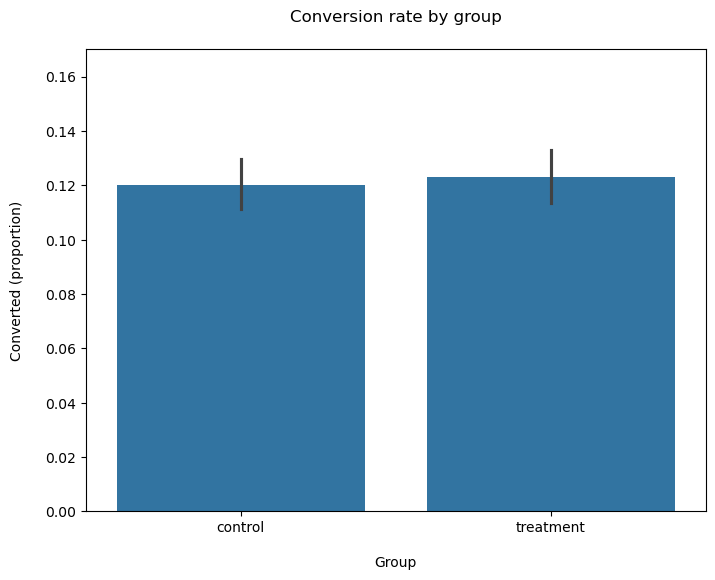

In [13]:
# Overall, I'd say that the control group was trending more towards 12% conversion rather than the client's reported 13%
# Either way, there *is* a lift of 0.3% in the treatment group, but not the 2% we were looking for
# Chart!

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'])
errorbar=('ci', False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);


In [14]:
# So we've done a whole lot, but we've not yet tested our hypothesis.  We've just selected our populations.
# We have various stats we can pull here and can use statsmodels.stats.proportion to get p-value and confidence interval

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [15]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [16]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.41
p-value: 0.682
ci 95% for control group: [0.111, 0.129]
ci 95% for treatment group: [0.114, 0.132]


Our p-value is over our alpha level of 0.05 by a lot, so we can safely say that we cannot reject our null hypothesis in this instance.  Practically, this means that our new landing page didn't have the effect on conversions that we were looking for.  

A few additional things. 
- Looking at the ci for the control group, we just barely on the high end fall short of what the client said the conversions were (12.9% vs 13%)
- Our treatment barely gets over 13% on the high end, very short of the 15% we were looking to get
- The implication here is that we're probably not getting the results from the redesign that we're looking for.

We can always test/retest, and ought to if we have the time.  Perhaps our sampled population doesn't accurately reflect the reality, however, the parameters we chose for the statistical significance of our data was very reasonable.  Additional testing would probably confirm that the treatment isn't having much of an effect, even if the upper limits of our confidence intervals shift upward a bit with a different sample.